In [1]:
import pandas as pd
from nltk.metrics.distance import edit_distance
import random
import re
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch
from rlhfutils.rewards import allmathpreds, get_synth_rewards
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean
import sys
import numpy as np

sys.path.append('../src/')

/u/prasanns/miniconda3/envs/fixenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
from rlhfutils.dataproc import getfrac
from utils.eval.rewards import calculate_math_rewards

In [3]:
# bowdata = Dataset.load_from_disk("../outputs/data/contrastivedistill/opt20k///")
# tmpsmall = getfrac(bowdata, 4000, False, False)

In [4]:
# tmpsmall.save_to_disk("../outputs/data/contrastivedistill/opt4k///")

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
calculate_math_rewards("(((3 * 8) * 1) * 3) = ((24 hi 1) * 3) = (23 * 3) = 89 = 72 ")

[0, -1, -1, -2]

In [7]:
# get reward for closest option
def allscomath(pred):
    inp = pred.split("=")[0].strip()
    allgolds = set([" = ".join(solve_expression(inp)) for i in range(20)])
    options = list([sum(calculate_math_rewards(pred, g)) for g in allgolds])
    #print(options)
    reward = max(options)
    return reward, allgolds

In [7]:
tmpmath = pd.read_json("../outputs/results/genouts/math/orig.jsonl", orient='records', lines=True)

In [26]:
# make math outputs into a pref dataset (some weirdness strangely enough)
rws = []
ags = []
kinds = []
for i, row in tmpmath.iterrows():
    tmprs = []
    for r in row['response']: 
        rw, g = allscomath(r) 
        tmprs.append(rw)
    if min(tmprs)==max(tmprs):
        continue
    ags.append(list(g))
    rws.append(tmprs) 
    kinds.append(i)
nmath = tmpmath.iloc[kinds]
nmath['reward'] = rws
nmath['ags'] = ags

weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird
weird


/tmp/ipykernel_3263259/1132248898.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nmath['reward'] = rws
/tmp/ipykernel_3263259/1132248898.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nmath['ags'] = ags


In [27]:
nmath

,question,response,reward,ags
0,(((6 - 6) * (2 - 1)) + 8),[(((6 - 6) * (2 - 1)) + 8) = ((0 * (2 - 1)) + ...,"[-9, -10, -11, -10]",[(((6 - 6) * (2 - 1)) + 8) = ((0 * (2 - 1)) + ...
1,((1 * 2) * (8 + 5)),[((1 * 2) * (8 + 5)) = ((2 * 2) * 13) = (4 * 1...,"[-9, -9, -9, -6]",[((1 * 2) * (8 + 5)) = (2 * (8 + 5)) = (2 * 13...
2,(((7 - 9) * 2) * (4 - (7 * 8))),[(((7 - 9) * 2) * (4 - (7 * 8))) = ((-2 * 2) *...,"[-14, -36, -25, -38]",[(((7 - 9) * 2) * (4 - (7 * 8))) = (((7 - 9) *...
4,((9 - 3) * (5 - 3)),[((9 - 3) * (5 - 3)) = ((9 - 3) * 2) = (6 * 2)...,"[-6, -6, -6, -14]",[((9 - 3) * (5 - 3)) = ((9 - 3) * 2) = (6 * 2)...
5,(((8 + 7) - (6 + 1)) - (9 - (3 + 8))),[(((8 + 7) - (6 + 1)) - (9 - (3 + 8))) = ((15 ...,"[-32, -33, -32, -21]",[(((8 + 7) - (6 + 1)) - (9 - (3 + 8))) = (((8 ...
...,...,...,...,...
991,(((4 + 5) * (9 + 7)) * ((5 - 8) * (6 * 4))),[(((4 + 5) * (9 + 7)) * ((5 - 8) * (6 * 4))) =...,"[-67, -76, -70, -82]",[(((4 + 5) * (9 + 7)) * ((5 - 8) * (6 * 4))) =...
993,((9 + 6) * 6),[((9 + 6) * 6) = (15 * 6) = 90 = 270 = 210 = 1...,"[-4, -15, -12, -12]",[((9 + 6) * 6) = (15 * 6) = 90]
996,(((8 + 6) + 7) + (9 - 4)),[(((8 + 6) + 7) + (9 - 4)) = ((14 + 7) + (9 - ...,"[-8, -8, -14, -10]",[(((8 + 6) + 7) + (9 - 4)) = ((14 + 7) + (9 - ...
997,(((8 - 6) * (3 + 6)) + 8),[(((8 - 6) * (3 + 6)) + 8) = ((2 * (3 + 6)) + ...,"[-47, -22, -8, -8]",[(((8 - 6) * (3 + 6)) + 8) = (((8 - 6) * 9) + ...


In [64]:
msft = Dataset.load_from_disk("../outputs/data/math/mdpomargin2/")

In [65]:
def fixmpref(ex):
    ex['response_j'] = " = "+ex['response_j']
    ex['response_k'] = " = "+ex['response_k']
    return ex

In [62]:
ms[0]

{'question': '(((6 - 6) * (2 - 1)) + 8)',
 'response_j': ' = ((0 * (2 - 1)) + 8) = ((0 * 1) + 8) = (-0 + 8) = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8 = 8',
 'response_k': ' = ((0 * (2 - 1)) + 8) = ((0 * 1) + 8) = (-1 + 8) = 7 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5'}

In [63]:
# ms = msft.map(fixmpref)
# ms.save_to_disk("../outputs/data/math/mdpomargingver2/")

Saving the dataset (1/1 shards): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 92646.78 examples/s]


In [66]:
msftv = Dataset.from_dict({'outputs': [r['question']+r['response_j'] for r in msft]})

In [70]:
msftv.save_to_disk("../outputs/data/math/mbestofnsft/")

Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 121935.12 examples/s]


In [29]:
# nmath.to_json("nmath.json", orient='records', lines=True)

In [39]:
msftv = Dataset.from_dict({'outputs': [r['ags'][0] for i, r in nmath.iterrows()]})

In [43]:
# msftv.save_to_disk("../outputs/data/math/sftcompsmall")

Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 148533.19 examples/s]


In [35]:
def math_to_prefs(indf, goldj=False):
    ndata = []
    for i, row in indf.iterrows():
        rj = row['response'][np.argmax(row['reward'])]
        if goldj: 
            rj = row['ags'][0]
        rk = row['response'][np.argmin(row['reward'])]
        tmp = {
            'question':row['question'],
            'response_j':rj[rj.index("=")+2:],
            'response_k':rk[rk.index("=")+2:]
        }
        ndata.append(tmp)
    return Dataset.from_list(ndata)

In [36]:
mathpnew = math_to_prefs(nmath, True)

In [37]:
mathpnew.save_to_disk("../outputs/data/math/mdpomargingver")

Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 129224.99 examples/s]


In [38]:
mathpnew[0]

{'question': '(((6 - 6) * (2 - 1)) + 8)',
 'response_j': '((0 * (2 - 1)) + 8) = ((0 * 1) + 8) = (0 + 8) = 8',
 'response_k': '((0 * (2 - 1)) + 8) = ((0 * 1) + 8) = (-1 + 8) = 7 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5 = 5'}

In [8]:
mprefs = Dataset.load_from_disk("../outputs/data/math/mathprefdata/")

In [9]:
mprefs[0]

{'question': '(((3 * 4) - 2) - 1) = ',
 'response_j': '((12 - 2) - 1) = (13 - 1) = 8 = 9 = 8 = 9 = 9\n\n(13 - 1) = 8 = 7 = 7 = 7\n\n12 = 7 = 7\n\n12 = 7 = 7\n\n12 = 7\n\nM = 7\n\nM = 7\n\nM = 7\n\nM = 7\n\nM = 7\n\nM = 7\n\nM = 7\n\nM = 7',
 'response_k': '((12 - 2) - 1) = (9 - 1) = 8 = 7 = 7 = 7 = 7 = 7 = 7 = 7 = 7 = 7 = -7 = -7 = -7 = -7 = -7 = -7 = -63 = -63 = -63 = -63 = -63 = -63 = 539 = 493 = -549 = -5191 = -5491 = -5491 = -4971 = -4971 =',
 'score_j': 3.4722222222222223,
 'score_k': 3.194444444444444,
 'magnitude': 0.2777777777777781}

In [23]:
def goldover(ex):
    ex['response_j'] = " = ".join(solve_expression(ex['question'].split(" = ")[0], False)[1:])
    return ex

In [24]:
gmprefs = mprefs.map(goldover)

Map:  36%|████████████████████████████████▊                                                          | 18000/50000 [00:01<00:03, 9595.32 examples/s]

weird
-60 =!!!!


Map:  71%|███████████████████████████████████████████████████████████████▉                          | 35494/50000 [00:03<00:01, 12316.70 examples/s]

weird
-2 =!!! -6
weird
116 =!!!99 + 8)


Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 10276.52 examples/s]


In [25]:
gmprefs[0]

{'question': '(((3 * 4) - 2) - 1) = ',
 'response_j': '((12 - 2) - 1) = (10 - 1) = 9',
 'response_k': '((12 - 2) - 1) = (9 - 1) = 8 = 7 = 7 = 7 = 7 = 7 = 7 = 7 = 7 = 7 = -7 = -7 = -7 = -7 = -7 = -7 = -63 = -63 = -63 = -63 = -63 = -63 = 539 = 493 = -549 = -5191 = -5491 = -5491 = -4971 = -4971 =',
 'score_j': 3.4722222222222223,
 'score_k': 3.194444444444444,
 'magnitude': 0.2777777777777781}

In [37]:
def generate_new_rows(row, indices=(0, 1, 2, 3, 4)):
    question = row['question']
    response_j = row['response_j']
    response_k = row['response_k']
    
    response_j_parts = response_j.split(' = ')
    response_k_parts = response_k.split(' = ')
    
    new_rows = []
    
    for idx in indices:
        if idx < len(response_j_parts) and idx < len(response_k_parts):
            prefix_j = ' = '.join(response_j_parts[:idx])
            new_question = question + prefix_j 
            new_response_j = response_j_parts[idx] if idx < len(response_j_parts) else ''
            new_response_k = response_k_parts[idx] if idx < len(response_k_parts) else ''
            new_row = {
                'question': new_question,
                'response_j': new_response_j,
                'response_k': new_response_k,
                'score_j': row['score_j'],
                'score_k': row['score_k'],
                'magnitude': row['magnitude']
            }
            new_rows.append(new_row)
    
    return new_rows

# Generate new dataset
new_data = []
for row in tqdm(gmprefs):
    new_data.extend(generate_new_rows(row))

new_df = pd.DataFrame(new_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 18281.90it/s]


In [52]:
tmpfgdata = Dataset.from_pandas(new_df)

In [55]:
tmpfgdataheld = tmpfgdata.select(range(214000, len(tmpfgdata)))
tmpfgdata = tmpfgdata.select(range(200000))

In [56]:
tmpfgdataheld.save_to_disk("../outputs/data/math/fgheld")

Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████████| 1826/1826 [00:00<00:00, 264817.92 examples/s]


In [57]:
tmpfgdata.save_to_disk("../outputs/data/math/fgpref200k/")

Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████| 200000/200000 [00:00<00:00, 815487.30 examples/s]


In [42]:
allscomath(tmpmath['response'][1][2])

-26

In [18]:
def generate_expression_with_depth(depth, current_depth=""):
    # operation will be fixed for each layer
    operation = random.choice(['+', '-', '*'])

    def randexp(giveexp, ndepth):
        if giveexp: 
            giveexp = random.choice([True, False])
            if 'r' not in ndepth:
                giveexp=True
        # giveexp = givenum or ('r' not in nstr)
        return generate_expression_with_depth(depth, ndepth) if giveexp else random.randint(1,9)

    left_expr = randexp(len(current_depth)<depth, current_depth+'l')
    right_expr = randexp(len(current_depth)<depth, current_depth+'r')
    return f"({left_expr} {operation} {right_expr})" 

def solve_expression(expression, rord=True):
    steps = [expression]
    # Use a loop to solve the expression step by step
    while '(' in expression or '+' in expression or '-' in expression or '*' in expression:
        # Solve the innermost parentheses first
        inner_parentheses = re.findall(r'\([^\(\)]*\)', expression)
        if inner_parentheses:
            random.shuffle(inner_parentheses)
            for ip in inner_parentheses:
                # Evaluate the expression inside the parentheses
                try: 
                    result = eval(ip)
                except: 
                    result = 0
                    print("weird")
                expression = expression.replace(ip, str(result), 1)
                steps.append(expression)
        else:
            # If no parentheses are left, solve the remaining expression
            try: 
                result = eval(expression)
            except: 
                result = 0
                print("weird")
                print(expression)
            expression = str(result)
            steps.append(expression)
            break
    return steps
    

In [9]:
# Example: Generate an expression with a depth of 3
depth = 2
expression_with_depth = generate_expression_with_depth(depth)
solution_steps_with_depth = solve_expression(expression_with_depth)

expression_with_depth, solution_steps_with_depth

('(((6 * 7) + 1) * ((6 - 5) - (8 + 6)))',
 ['(((6 * 7) + 1) * ((6 - 5) - (8 + 6)))',
  '(((6 * 7) + 1) * ((6 - 5) - 14))',
  '(((6 * 7) + 1) * (1 - 14))',
  '((42 + 1) * (1 - 14))',
  '(43 * (1 - 14))',
  '(43 * -13)',
  '-559',
  '-559'])

In [19]:
expression_with_depth = generate_expression_with_depth(2)
ls = set()
for i in range(10):
    ls.add(" = ".join(solve_expression(expression_with_depth)))
print(len(ls))
print(ls)

4
{'(((1 - 1) + 7) * (1 - (5 + 4))) = ((0 + 7) * (1 - (5 + 4))) = ((0 + 7) * (1 - 9)) = (7 * (1 - 9)) = (7 * -8) = -56 = -56', '(((1 - 1) + 7) * (1 - (5 + 4))) = ((0 + 7) * (1 - (5 + 4))) = ((0 + 7) * (1 - 9)) = ((0 + 7) * -8) = (7 * -8) = -56 = -56', '(((1 - 1) + 7) * (1 - (5 + 4))) = (((1 - 1) + 7) * (1 - 9)) = ((0 + 7) * (1 - 9)) = (7 * (1 - 9)) = (7 * -8) = -56 = -56', '(((1 - 1) + 7) * (1 - (5 + 4))) = (((1 - 1) + 7) * (1 - 9)) = ((0 + 7) * (1 - 9)) = ((0 + 7) * -8) = (7 * -8) = -56 = -56'}


In [17]:
eval("(((7 - 2) - (1 - 6)) * 1)")

10

In [8]:
random.randint(0,3)

3

In [20]:
def makesftdset(depth=2, dsetsize=1000): 
    exprs = [generate_expression_with_depth(random.randint(1,depth)) for i in range(dsetsize)]
    steps = [' = '.join(solve_expression(e)) for e in exprs]
    return Dataset.from_dict({'question': exprs, 'outputs':steps})

In [30]:
def allouts(ex):
    tmpouts = set()
    for i in range(15):
        tmpouts.add(" = ".join(solve_expression(expression_with_depth)))
    ex['allouts'] = list(tmpouts)
    ex['numposs'] = len(ex['allouts'])
    return ex

In [35]:
mdata = mdata.map(allouts, num_proc=10)

Map (num_proc=10): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 784.71 examples/s]


In [36]:
len(mdata)

200

In [34]:
mdata = makesftdset(depth=2, dsetsize=200)

In [37]:
# mdata.save_to_disk("../outputs/data/math/mrandomheld")

Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 31835.32 examples/s]


In [32]:
# mdata.save_to_disk("../outputs/data/math/mrandominps")

Saving the dataset (1/1 shards): 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 91474.83 examples/s]


In [42]:
resprange = []
for m in tqdm(allms['outputs']): 
    resprange.append(int(m.split(" = ")[-1]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 833319/833319 [00:00<00:00, 2177929.30it/s]


In [41]:
allms = mdata.filter(lambda ex: abs(int(ex['outputs'].split(" = ")[-1]))<99)

Filter: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 417899.76 examples/s]


In [46]:
allms.save_to_disk("../outputs/data/math/mathsfthuge")

Saving the dataset (1/1 shards): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 833319/833319 [00:01<00:00, 440524.23 examples/s]


(array([  5447.,  10216.,  18613.,  36161., 150683., 338728., 130427.,
         69988.,  45853.,  27203.]),
 array([-98. , -78.4, -58.8, -39.2, -19.6,   0. ,  19.6,  39.2,  58.8,
         78.4,  98. ]),
 <BarContainer object of 10 artists>)

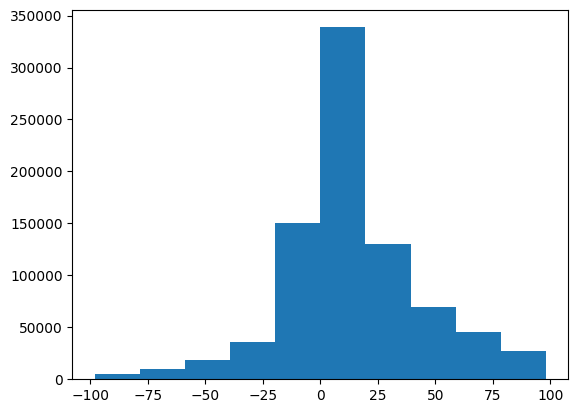

In [43]:
plt.hist(resprange)

In [23]:
# mdata.save_to_disk("../../data/math/mathsfthuge")

Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 899816.34 examples/s]


In [7]:
# CODE TO MAKE INITIAL SFT MODELS
# mathdata = makesftdset()
# mathdata.save_to_disk("../../data/math/mathsftinitial")

In [12]:
allgens = genall(mod, mathprefdata['question'], 512)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [09:26<00:00,  2.89s/it]


In [17]:
prefdset = mathprefs(allgens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:31<00:00, 543.88it/s]


In [37]:
prefdsetc = prefdsetc.map(correct_prefs, num_proc=10)

In [45]:
mean(prefdset['score_k'] + prefdset['score_j'])

3.1381721644525453

In [39]:
prefdsetc.save_to_disk("../../data/math/mathprefdata")

(array([25733., 13054.,  5631.,  2225.,   930.,   857.,   851.,   451.,
          137.,   131.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

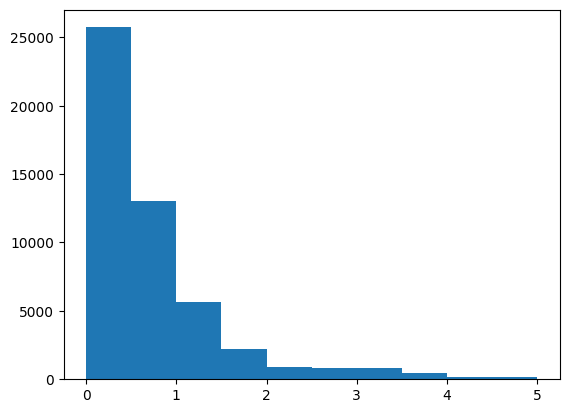

In [34]:
plt.hist(prefdsetc['magnitude'])

In [6]:
# def correct_prefs(ex):
#     tmpjr = ex['response_j']
#     tmpsr = ex['score_j']
#     ex['magnitude'] = -1 * ex['magnitude']
#     ex['response_j'] = ex['response_k']
#     ex['score_j'] = ex['score_k']
#     ex['response_k'] = tmpjr
#     ex['score_k'] = tmpsr
#     return ex

def correct_prefs(ex):
    
    ex['response_j'] = ex['response_j'].strip()
    ex['response_k'] = ex['response_k'].strip()
    
    return ex

In [8]:
# CODE TO MAKE PPO DATASET
def procinps(ex):
    ex['question'] = ex['question'] + " = "
    return ex

def genall(md, text_list, bs=16):
    newgens = []
    ntl = []
    for t in text_list:
        ntl.extend([t]*2)
    for i in tqdm(range(0, len(ntl), bs)):
        inps = tok(ntl[i:i+bs], return_tensors="pt", padding=True, truncation=True).to(mod.device)
        out = mod.generate(**inps, do_sample=True, top_p=1, max_new_tokens=100, min_new_tokens=-1)
        newgens.extend(tok.batch_decode(out, skip_special_tokens=True))
    return newgens

def mathprefs(genlist): 
    alldata = []
    for i in tqdm(range(0, len(genlist), 2)):
        tmp = {
            'question':genlist[i].split(" = ")[0] + " = ", 
        }
        resps = [g[len(tmp['question']):] for g in genlist[i:i+2]]
        scos = allmathpreds(resps)
        jind = 0 if scos[0]>scos[1] else 0
        tmp['response_j'] = resps[jind]
        tmp['response_k'] = resps[1-jind]
        tmp['score_j'] = scos[jind]
        tmp['score_k'] = scos[1-jind]
        tmp['magnitude'] = tmp['score_j'] - tmp['score_k']
        alldata.append(tmp)
    return Dataset.from_list(alldata)
        
    
ppodata = makesftdset(2, 200000)
ppodata = ppodata.filter(lambda ex: abs(int(ex['outputs'].split(" = ")[-1]))<99)
ppodata = ppodata.map(procinps, num_proc=10)
# ppodata.save_to_disk("../../data/math/mathppoinpseasy2")

Map (num_proc=10): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166610/166610 [00:01<00:00, 94281.83 examples/s]


In [10]:
ppodata.save_to_disk("../outputs/data/math/moreppoinps")

Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166610/166610 [00:00<00:00, 1090734.69 examples/s]


In [24]:
ppodata[0]

{'question': '(7 * 2) = ', 'outputs': '(7 * 2) = 14'}

In [25]:
ppodata.save_to_disk("../outputs/data/math/matheasy1")

In [26]:
ppodata[3]

{'question': '(6 - 2) = ', 'outputs': '(6 - 2) = 4'}

In [10]:
easy2 = ppodata.filter(lambda ex: ex['question'].count("(")<=2)


In [12]:
easy2.save_to_disk("../outputs/data/math/easy2_100k")

(array([     0.,      0.,      0.,      0.,      0., 100225.,      0.,
             0.,      0.,      0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <BarContainer object of 10 artists>)

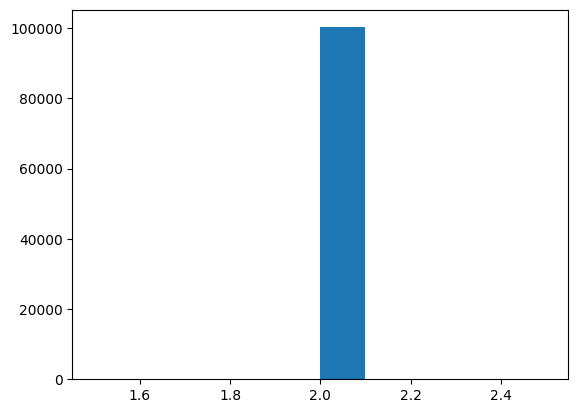

In [14]:
plt.hist([q.count("(") for q in easy2['question']])

In [10]:
mathprefdata = makesftdset()
mathprefdata = mathprefdata.map(procinps, num_proc=10)

NameError: name 'procinps' is not defined

In [11]:
# check whether this thing actually works or not
tok = AutoTokenizer.from_pretrained("facebook/opt-125m", padding_side='left')
mod = AutoModelForCausalLM.from_pretrained("facebook/opt-125m", device_map=3, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2")
mod = PeftModel.from_pretrained(mod, "../../checkpoints/math/mathsftinitial_sft/checkpoint-1300/")

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
testset = makesftdset(2, 1000)

In [63]:
def a(input, val):
    return val

In [64]:
tup = tuple([0])
tup = tup + tuple([9])
a(*tup)

9

In [17]:
ind = 1
inpstr = testset['question'][ind]+" = "
inps = tok(inpstr, return_tensors="pt").to(mod.device)
out = mod.generate(**inps, do_sample=True, top_p=1, max_new_tokens=100, min_new_tokens=-1, num_return_sequences=2)
# print(tok.batch_decode(out, skip_special_tokens=True)[0])
out = tok.batch_decode(out, skip_special_tokens=True)[0]
# print(testset['outputs'][ind])
# print(out)
# print(calculate_rewards(out, None, True))
# einstein_reward(out, stmp[0]['sol_rows'], True)

In [19]:
len(out)

254

In [38]:
# Example usage
predictions = ["((3 + 4) - (1 * 8)) * 1", "(7 - (1 * 8)) * 1", "(7 - 8) * 1", "-1 * 1"]
golds = ["((3 + 4) - (1 * 8)) * 1", "(7 - 8) * 1", "-1 * 1", "-1"]
rewards = calculate_rewards(predictions, golds)

rewards

[1.0, 0.7647058823529411, 0.6363636363636364, 0.6666666666666667]

In [76]:
def a(inp):
    print(inp)

In [70]:
from rlhfutils.rewards import allmathpreds

In [83]:
ts = ["((4)+1) = (4+1) = 4"]
inps = tuple([ts])

In [84]:
allmathpreds(*inps)

[2.5]

In [3]:
bowdata = Dataset.load_from_disk("../../data/bagofwords/nozero100k/")

In [11]:
get_synth_rewards([bowdata[0]['response_k']], 'bagofwords')

[0.0]

In [2]:
# do some paraphrase dataset prep
vals = load_dataset("jpwahle/machine-paraphrase-dataset")

Generating train split: 200767 examples [00:04, 42076.01 examples/s]
Generating test split: 384291 examples [00:08, 45056.20 examples/s]


In [11]:
def shortenstr(s, lim=300):
    tmp = s[:lim]
    return tmp[:tmp.rfind(".")+1]

In [12]:
shortenstr(vals['test'][0]['text'])

'It is vital to know what feature properties in portion mechanics represent traditional chaos. Many writers have devoted their own efforts on this subject matter. It is, now, popular that for K-system its level space distribution has a general form, i. electronic., Wigner distribution.'

In [13]:
newdata = {
    'question': [shortenstr(v) for v in vals['test']['text']]
}

In [14]:
tmpdata = Dataset.from_dict(newdata)

In [15]:
tmpdata.save_to_disk("../outputs/data/paraphrase/parappoinps")

Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384291/384291 [00:00<00:00, 469983.49 examples/s]


In [17]:
from nltk import word_tokenize

In [25]:
a1 = set(word_tokenize("Hi there I'm bob, I'm flying"))
a2 = set(word_tokenize("Hi I can't help but fly there"))
a1.union(a2)

{"'m",
 ',',
 'Hi',
 'I',
 'bob',
 'but',
 'ca',
 'fly',
 'flying',
 'help',
 "n't",
 'there'}

In [55]:
len(word_tokenize(tmpdata['question'][1000]))

42

In [27]:
from statistics import mean

In [51]:
edist("hi there my big fat boy who can't eat chicken", "fat boy eat's things every day")

0.6818181818181818